## Training procedure: VGG_Unet

### Download training data

In [3]:
from utils.download import download_training_data

download_training_data(target_dir='data')

Target directory exists: data\mars_data_20210923


### Run tensorboard

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs

### Model configuration and training

In [6]:
from keras_segmentation.models.unet import vgg_unet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from datetime import datetime

# define model 
model = vgg_unet(n_classes=3, input_height=480, input_width=480, channels=1 )

timestamp = str(datetime.now()).replace(' ', '_').replace(':','')
log_dir = 'logs/' + model.model_name + '_' + timestamp
checkpoint_path = log_dir +  '/checkpoints/' + model.model_name  

callbacks = [
    ModelCheckpoint(
                filepath = checkpoint_path + ".{epoch:05d}",
                save_weights_only=True,
                verbose=True
            ),
#     EarlyStopping(verbose=2, patience=3, monitor='val_accuracy', mode='max', restore_best_weights=True), 
    TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq=5)
]

# run training
model.train(
    train_images =  "data/mars_data_20210923/train/images/",
    train_annotations = "data/mars_data_20210923/train/annotations/",
    optimizer_name = 'adam', 
    batch_size = 20,
    steps_per_epoch = 512,
    checkpoints_path = checkpoint_path,
    epochs=50,
    val_images = "data/mars_data_20210923/val/images/",
    val_annotations = "data/mars_data_20210923/val/annotations",
    validate=True,
    val_steps_per_epoch=512,
    callbacks=callbacks,
    read_image_type=0,
    do_augment=True,
    ignore_zero_class=False
)

Verifying training dataset


100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 170.67it/s]


Dataset verified! 
Verifying validation dataset


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 165.29it/s]


Dataset verified! 
Epoch 1/50
1/2 [==============>...............] - ETA: 0s - loss: 2.0030 - accuracy: 0.2066WARNING:tensorflow:From C:\Users\grochu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2/2 [==============================] - ETA: 0s - loss: 1.7719 - accuracy: 0.1833WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0310s vs `on_train_batch_end` time: 0.1580s). Check your callbacks.

Epoch 00001: saving model to logs_4/vgg_unet_2021-10-17_183035.851354/checkpoints\vgg_unet.00001
2/2 [==============================] - 2s 1s/step - loss: 1.7719 - accuracy: 0.1833 - val_loss: 12.4979 - val_accuracy: 0.0032
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 1.2292 - accuracy: 0.5146
Epoch 00002: savi

KeyboardInterrupt: 

## Prediction

### Load model from checkpoint

In [21]:
from keras_segmentation.predict import model_from_checkpoint_path
from pathlib import Path

checkpoint_path = 'models/unet_mini_2021-09-27_003743.848447/unet_mini'
model = model_from_checkpoint_path(str(Path(checkpoint_path)))

print(model.summary())

loaded weights  models\unet_mini_2021-09-27_003743.848447\unet_mini.00014
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 480, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 480, 480, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 480, 480, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 480, 480, 32) 9248        dropout_10[0][0]                 
____________

### Predict sample image

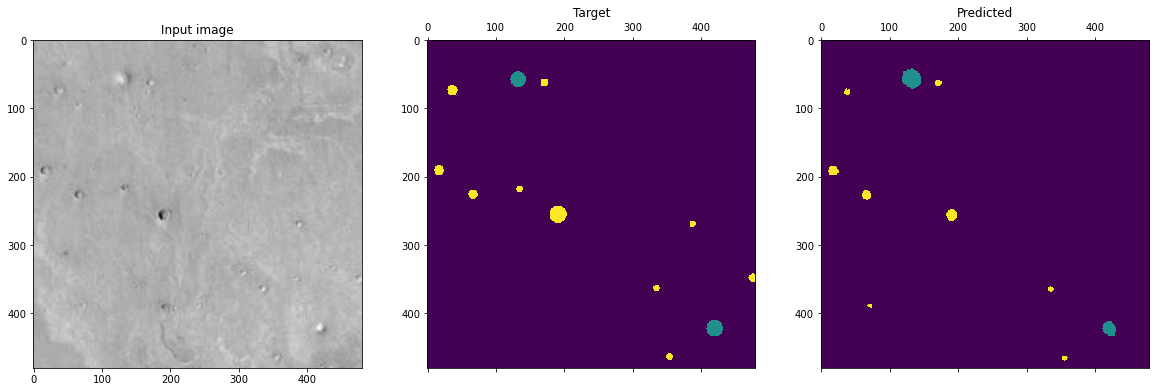

In [24]:
from keras_segmentation import predict
import cv2
import matplotlib.pyplot as plt

inp_img = 'data/sample/image/unnamed_testing_1_patch_005_00240_00240_r0.10.png'
ann_img = 'data/sample/annotations/unnamed_testing_1_patch_005_00240_00240_r0.10.png'

prediction = predict.predict(model=model, inp=inp_img, out_fname=None, read_image_type=0 )

inp = cv2.imread(inp_img, 0)
ann = cv2.imread(ann_img, 1)

fig, ax = plt.subplots(1, 3, figsize=(20,7))
ax[0].imshow(inp, cmap='gray')
ax[0].set_title('Input image')
ax[1].matshow(ann[:,:,0], vmin=0)
ax[1].set_title('Target')
ax[2].matshow(prediction, vmin=0)
ax[2].set_title('Predicted')
plt.show()

### Object detection

cone detected 2 objects
crater detected 8 objects

cone

Region      area                   bbox          centroid        perimeter  solidity
    2        339       (412, 410, 434, 430)     422.6    420.2      70.0  0.955
    1        640         (43, 118, 73, 146)      57.1    131.7      98.5  0.948

crater

Region      area                   bbox          centroid        perimeter  solidity
    7         38         (386, 67, 392, 75)     388.3     70.7      21.1  0.927
    8         46       (462, 351, 470, 360)     465.3    354.9      24.1  0.902
    6         53       (361, 331, 369, 340)     364.4    334.8      25.3  0.946
    1         66         (60, 167, 69, 176)      63.7    170.8      27.3  0.971
    2         66           (72, 34, 81, 43)      76.3     38.2      29.1  0.917
    4        149         (220, 60, 235, 73)     227.2     66.1      43.2  0.955
    3        167         (186, 10, 199, 26)     192.0     17.4      46.4  0.954
    5        215       (248, 183, 266, 198) 

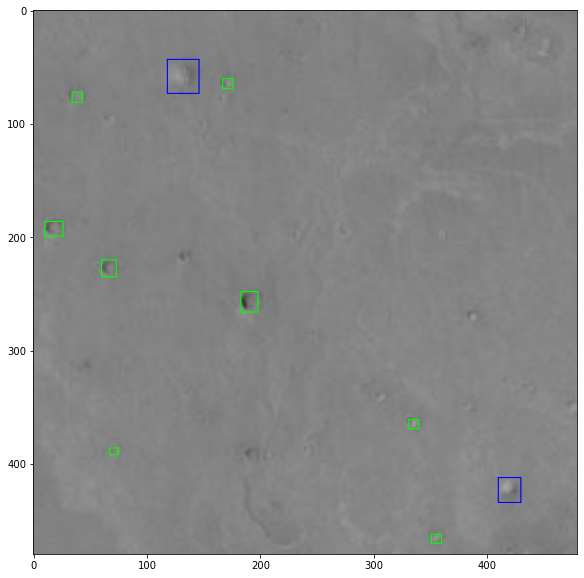

In [29]:
from detect import detect_cones_and_craters, print_detections, draw_regions2

results = detect_cones_and_craters(labels=prediction, min_area=10, min_perimeter=5, min_solidity=0.5)

print_detections(results)

image_reg = draw_regions2(inp, results, thickness=1)
plt.figure(figsize=(10,10))
plt.imshow(image_reg)

## Object detection on large image

Image original size: 11812x11812
loaded weights  models\unet_mini_2021-09-27_003743.848447\unet_mini.00014
Model input shape (None, 480, 480, 1)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.60it/s]


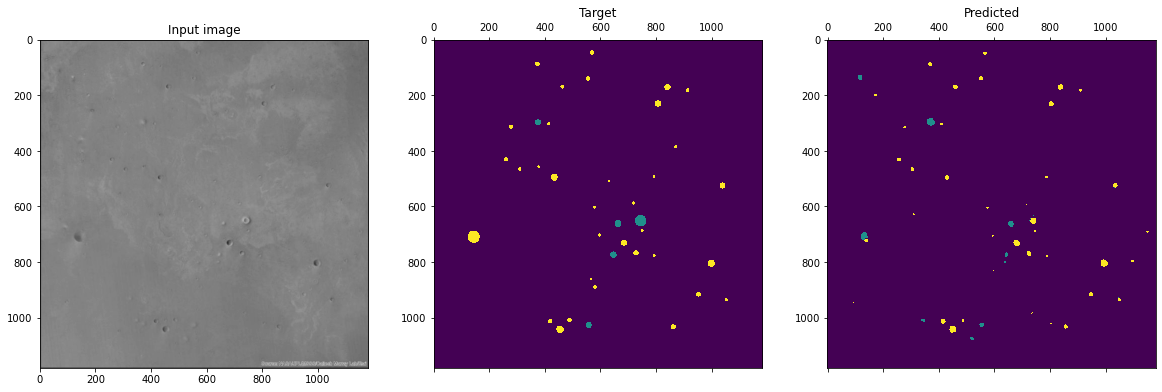

In [21]:
from predict_and_detect import predict_large_image
from utils.image import image_to_labelmap
import cv2

# Large MARS image in 1:500K scale
input_file = 'data/test/scale_500K/unnamed_testing_1.png'

checkpoint_path = 'models/unet_mini_2021-09-27_003743.848447/unet_mini'

prediction, image = predict_large_image(input_file, resize_ratio=0.1, checkpoint_path=checkpoint_path)

mask_file = 'data/test/scale_500K/unnamed_testing_1_mask.png'
mask_img = cv2.imread(mask_file, 1)
mask_img = cv2.resize(mask_img, (image.shape), interpolation=cv2.INTER_NEAREST)

fig, ax = plt.subplots(1, 3, figsize=(20,7))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input image')
ax[1].matshow(image_to_labelmap(mask_img), vmin=0)
ax[1].set_title('Target')
ax[2].matshow(prediction, vmin=0)
ax[2].set_title('Predicted')
plt.show()

cone detected 16 objects
crater detected 44 objects
Removing region, area 3, perimeter 1.000000, solidity 1.000000
Removing region, area 1, perimeter 0.000000, solidity 1.000000
Removing region, area 3, perimeter 1.000000, solidity 1.000000
Removing region, area 1, perimeter 0.000000, solidity 1.000000
Removing region, area 2, perimeter 0.000000, solidity 1.000000
Removing region, area 3, perimeter 1.000000, solidity 1.000000
Removing region, area 1, perimeter 0.000000, solidity 1.000000
Removing region, area 1, perimeter 0.000000, solidity 1.000000
Removing region, area 4, perimeter 2.000000, solidity 1.000000
Removing region, area 2, perimeter 0.000000, solidity 1.000000
Removing region, area 8, perimeter 8.000000, solidity 1.000000
Removing region, area 2, perimeter 0.000000, solidity 1.000000
Removing region, area 2, perimeter 0.000000, solidity 1.000000

cone

Region      area                   bbox          centroid        perimeter  solidity
    4         13     (529, 1028, 534,

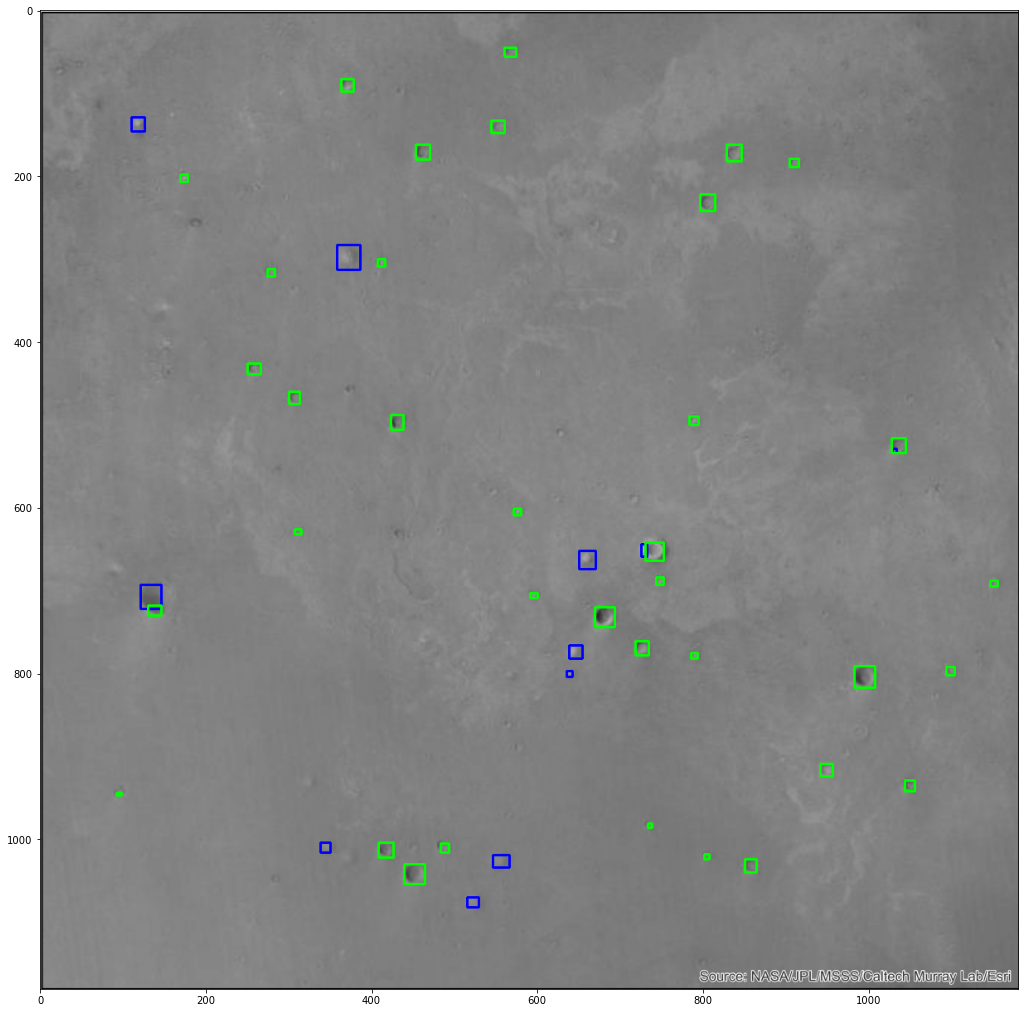

In [10]:
from detect import detect_cones_and_craters, print_detections, draw_regions2

results = detect_cones_and_craters(labels=prediction, min_area=10, min_perimeter=5, min_solidity=0.5)

print_detections(results)

image_reg = draw_regions2(image, results, thickness=2)
plt.figure(figsize=(18, 18))
plt.imshow(image_reg)